# Model for AIQ  

In this notebook, we develop the models for the transformed dataset considering the exogenous variable to be the **AIQ**.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
from utilities import Utilities

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

## Definitions for the notebook

In [4]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [5]:
air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

,year,month,day,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,...,CO_lag24,CO_MA24,O3_lag1,O3_lag2,O3_lag24,O3_MA24,PM10_lag1,PM10_lag2,PM10_lag24,PM10_MA24
0,2011,1,2,1,-22.965,-43.180,3.617,-1.530,-1.128,-0.140,...,-0.763,-0.936,-0.738,-0.543,-1.190,-0.365,0.101,0.078,0.087,0.082
1,2011,1,2,7,-22.898,-43.222,-0.272,-1.513,-0.565,0.560,...,-1.678,-1.232,-0.612,-0.997,-0.724,-0.187,-0.307,-0.967,-1.858,-1.136
2,2011,1,2,3,-22.908,-43.178,3.617,-1.557,-0.720,-0.470,...,-0.634,-0.166,-0.211,-0.717,-0.169,-0.027,-0.677,-0.677,-1.617,-1.141
3,2011,1,2,8,-22.925,-43.233,3.617,-1.909,-0.194,-1.068,...,-0.897,-1.283,-0.267,-0.184,-1.028,0.274,-0.773,-0.583,0.495,-1.061
4,2011,1,2,7,-22.898,-43.222,3.617,-1.658,-0.567,0.548,...,-1.591,-1.206,-1.300,-0.612,-1.099,-0.204,-0.484,-0.307,-0.967,-1.136


## Inverse Power Transformation 

Just for future transformations on ozone data. 

In [6]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_o3 = df_train[df_train.CodNum==8].O3
y_test_o3 = df_test[df_test.CodNum==8].O3
y_train_co = df_train[df_train.CodNum==8].CO
y_test_co = df_test[df_test.CodNum==8].CO
y_train_pm10 = df_train[df_train.CodNum==8].PM10
y_test_pm10 = df_test[df_test.CodNum==8].PM10
y_train_aiq = df_train[df_train.CodNum==8].aiq
y_test_aiq = df_test[df_test.CodNum==8].aiq

del df_train, df_test

## Polynomial and interaction terms

In [9]:
poly = PolynomialFeatures(2)

x_train_SP_poly = pd.DataFrame(poly.fit_transform(x_train_SP), 
                               columns = poly.get_feature_names(x_train_SP.columns), 
                               index = x_train_SP.index)
x_test_SP_poly = pd.DataFrame(poly.fit_transform(x_test_SP), 
                              columns = poly.get_feature_names(x_test_SP.columns),
                              index = x_test_SP.index)

## Best features

In [10]:
best_features_o3 = ['year O3_lag1', 'RS', 'RS hour_cos', 'year Vel_Vento', 'O3_lag2', 
                    'year O3_MA24', 'hour_cos PM10_lag1', 'RS Temp', 'RS O3_lag2', 'O3_lag1^2']
best_features_co = ['CO_lag1', 'hour_sin^2', 'CO_lag24', 'hour_cos', 'year Vel_Vento',
                    'CO_MA24', 'RS PM10_lag1', 'CO_lag2', 'Vel_Vento^2']

## AIQ calculus

In [46]:
def coef_calculator(i, gas_name): 
    """
    Calculate the AIQ coefficients for a specific gas and level.
    """
    gas = change_points[gas_name]
    index = change_points["Index"]
    b = (index[i]+1) - (index[i+1]-(index[i]+1))/(gas[i+1] - (gas[i]+1))*(gas[i]+1)
    a = (index[i+1] - (index[i]+1))/(gas[i+1] - (gas[i] + 1))
    return (a, b)

change_points = {
    "Index": [-1,40,80,120,200,400],
    "PM10": [-1,50,100,150,250,1000],
    "CO": [-1,9,11,13,15,50],
    "O3": [-1,100,130,160,200,800]
}

# precalculated coefficients
coefficients = {key: [coef_calculator(i,key) for i in range(5)] for key in ["PM10","CO","O3"]}

def get_aiq_group(value): 
    for i in range(5): 
        if value <= change_points['Index'][i]:
            return 'N' + str(i)
    return 'N5'

def calc_aic(row, gas_name):
    value = row[gas_name]
    for i, v in enumerate(change_points[gas_name]):
        if value < v: 
            return coefficients[gas_name][i-1][0]*value + coefficients[gas_name][i-1][1]
    print(row)

## O3 model

In [12]:
svr_o3 = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = 0.2, 
                        C = 1.0,
                        max_iter = 200000))

svr_o3.fit(x_train_SP_poly[best_features_o3], y_train_o3)

## CO model

In [13]:
rand_forest_co = RandomForestRegressor(n_estimators = 500, 
                                       criterion = 'mse', 
                                       min_samples_split = 5, 
                                       max_features = 'sqrt',
                                       ccp_alpha = 0.0,
                                       n_jobs = 2)

rand_forest_co.fit(x_train_SP_poly[best_features_co], y_train_co)

## PM10 model

In [14]:
rand_forest_pm10 = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs = 2,
                                    )
rand_forest_pm10.fit(x_train_SP, y_train_pm10)

## AIQ Model

In [ ]:
y_pred_o3 = svr_o3.predict(x_test_SP_poly[best_features_o3])
y_pred_co = rand_forest_co.predict(x_test_SP_poly[best_features_co])
y_pred_pm10 = rand_forest_pm10.predict(x_test_SP)

y_pred_train_o3 = svr_o3.predict(x_train_SP_poly[best_features_o3])
y_pred_train_co = rand_forest_co.predict(x_train_SP_poly[best_features_co])
y_pred_train_pm10 = rand_forest_pm10.predict(x_train_SP)

In [33]:
transformed = pd.DataFrame({
    'O3': pt_gases['O3'].inverse_transform(y_pred_o3.reshape(-1,1)).flatten(),
    'CO': pt_gases['CO'].inverse_transform(y_pred_co.reshape(-1,1)).flatten(),
    'PM10': pt_gases['PM10'].inverse_transform(y_pred_pm10.reshape(-1,1)).flatten(),
    }
)
transformed_train = pd.DataFrame({
    'O3': pt_gases['O3'].inverse_transform(y_pred_train_o3.reshape(-1,1)).flatten(),
    'CO': pt_gases['CO'].inverse_transform(y_pred_train_co.reshape(-1,1)).flatten(),
    'PM10': pt_gases['PM10'].inverse_transform(y_pred_train_pm10.reshape(-1,1)).flatten()
})

transformed["aiq"] = transformed.apply(lambda row: max(calc_aic(row, "O3"), 
                                                       calc_aic(row, "CO"), 
                                                       calc_aic(row, "PM10")), 
                                       axis = 1)
transformed_train["aiq"] = transformed_train.apply(lambda row: max(calc_aic(row, "O3"), 
                                                                   calc_aic(row, "CO"), 
                                                                   calc_aic(row, "PM10")), 
                                                   axis = 1)

In [35]:
r2_train = r2_score(y_train_aiq, transformed_train["aiq"] )
r2_test  = r2_score(y_test_aiq, transformed["aiq"])
mae_train = mean_absolute_error(y_train_aiq, transformed_train["aiq"] )
mae_test  = mean_absolute_error(y_test_aiq, transformed["aiq"])
rmse_train = mean_squared_error(y_train_aiq, transformed_train["aiq"], squared = False)
rmse_test  = mean_squared_error(y_test_aiq, transformed["aiq"], squared = False)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8891585786699359
MAE train set: 3.0592247054520656
RMSE train set: 5.82456500571222
R2 test set: 0.7462250808476643
MAE test set: 3.956236272674714
RMSE test set: 6.874891521262451


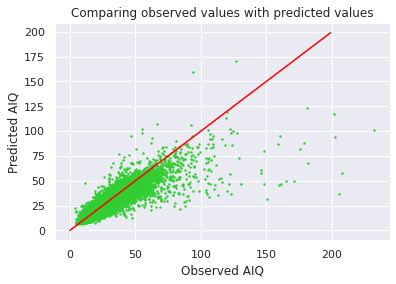

In [57]:
plt.scatter(y_test_aiq, transformed.aiq, s=2, color = 'limegreen')
plt.plot(range(0,200),range(0,200), color = 'red')
plt.xlabel("Observed AIQ")
plt.ylabel("Predicted AIQ")
plt.title("Comparing observed values with predicted values");
plt.savefig(IMAGES_FOLDER + 'observed-vs-predicted-aiq.eps', bbox_inches = 'tight')

## Final model

In [16]:
air_data_SP = air_data[air_data.CodNum == 8].drop(columns=['Lat', 'Lon', 'train', 'CodNum']).reset_index(drop=True)

y_train_o3 = air_data_SP.O3
y_train_co = air_data_SP.CO
y_train_pm10 = air_data_SP.PM10
y_train_aiq = air_data_SP.aiq

air_data_SP.drop(columns=["O3", 'CO', 'PM10', 'aiq'], inplace = True)

air_data_SP_poly = pd.DataFrame(poly.fit_transform(air_data_SP), 
                                columns = poly.get_feature_names(air_data_SP.columns), 
                                index = air_data_SP.index)

In [17]:
svr_o3.fit(air_data_SP_poly[best_features_o3], y_train_o3)
rand_forest_co.fit(air_data_SP_poly[best_features_co], y_train_co)
rand_forest_pm10.fit(air_data_SP, y_train_pm10)

RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=500, n_jobs=2)

## AIQ Model

In [18]:
y_pred_o3 = svr_o3.predict(air_data_SP_poly[best_features_o3])
y_pred_co = rand_forest_co.predict(air_data_SP_poly[best_features_co])
y_pred_pm10 = rand_forest_pm10.predict(air_data_SP)

In [56]:
transformed = pd.DataFrame({
    'O3': pt_gases['O3'].inverse_transform(y_pred_o3.reshape(-1,1)).flatten(),
    'CO': pt_gases['CO'].inverse_transform(y_pred_co.reshape(-1,1)).flatten(),
    'PM10': pt_gases['PM10'].inverse_transform(y_pred_pm10.reshape(-1,1)).flatten(),
    }
)

transformed["aiq"] = transformed.apply(lambda row: max(calc_aic(row, "O3"), 
                                                       calc_aic(row, "CO"), 
                                                       calc_aic(row, "PM10")), 
                                       axis = 1)

transformed[['year','month']] = air_data_SP[['year','month']]
transformed['AIQ Level'] = transformed.aiq.apply(get_aiq_group)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


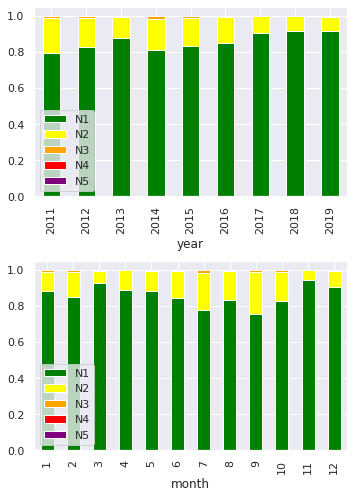

In [69]:
fig, ax = plt.subplots(2,1,figsize = (5,7))
(transformed.groupby('year')['AIQ Level'].value_counts(normalize=True)
    .unstack('AIQ Level').plot.bar(stacked=True, ax=ax[0], 
                                   color = ['green','yellow','orange','red','purple'])
)
(transformed.groupby('month')['AIQ Level'].value_counts(normalize=True)
    .unstack('AIQ Level').plot.bar(stacked=True, ax=ax[1],
                                   color = ['green','yellow','orange','red','purple'])
)
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left')
fig.tight_layout(pad=1.0)

plt.savefig(IMAGES_FOLDER+"aiq-time.eps", bbox_inches='tight')

In [70]:
air_data_SP['aqi_level'] = air_data.aiq.apply(get_aiq_group)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


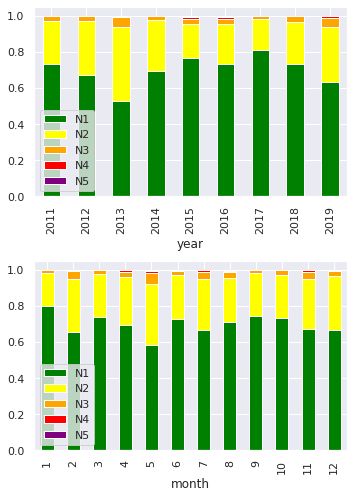

In [76]:
fig, ax = plt.subplots(2,1,figsize = (5,7))
(air_data_SP.groupby('year')['aqi_level'].value_counts(normalize=True)
    .unstack('aqi_level').plot.bar(stacked=True, ax=ax[0], 
                                   color = ['green','yellow','orange','red','purple'])
)
(air_data_SP.groupby('month')['aqi_level'].value_counts(normalize=True)
    .unstack('aqi_level').plot.bar(stacked=True, ax=ax[1],
                                   color = ['green','yellow','orange','red','purple'])
)
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left')
fig.tight_layout(pad=1.0)

plt.savefig(IMAGES_FOLDER+"aiq-time-observed.eps", bbox_inches='tight')